# Data Loader

The following code takes random samples from the h5 dataset (see previous notebook or the make features command) and empirically validates it.

It also contains some scrap code to efficiently generate batches.

In [1]:
%matplotlib notebook
import numpy as np
import h5py
import random

from matplotlib import animation

import os

from play_skeleton import *
from joints import *

ntu_path = "/media/gnocchi/Seagate Backup Plus Drive/NTU-RGB-D/"

rgb_folder = "nturgb+d_rgb/"
skeleton_folder = "nturgb+d_skeletons/"

h5_dataset_path = "/media/gnocchi/Seagate Backup Plus Drive/NTU-RGB-D/"
dataset_file_name = "datasets.h5"
log_file_name = "log.txt"

### Create list of samples from the log file (contains all sample names)

In [2]:
# Sample names in a list (total of 56880 samples)
samples_names_list = [line.rstrip('\n') for line in open(h5_dataset_path + log_file_name)]

# Take random elements from list
# 1. Shuffle elements
random.shuffle(samples_names_list)

# 2. Take first n elements
n = 10
batch = samples_names_list[:n]

# 3. Remove first n elements
new_samples_names_list = samples_names_list[n:]

### Separate between cross-view and cross-subject sets

S : setup number 

C : camera id

P : performer id

R : replication number

A : action label

In [3]:
# Cross subject
training_subjects = [1, 2, 4, 5, 8, 9, 13, 14, 15, 16, 17, 18, 19, 25, 27, 28, 31, 34, 35, 38]

# Cross view
training_cameras = [2, 3]

In [4]:
# Create strings with subject ids : ['P001', 'P002', ..., 'P038']
training_subjects_pxxx = []
for s in training_subjects:
    training_subjects_pxxx.append("P{:03d}".format(s))
    
# Create strings with camera ids : ['C002', 'C003']
training_cameras_cxxx = []
for s in training_cameras:
    training_cameras_cxxx.append("C{:03d}".format(s))
    

In [5]:
# Get cs training samples (40320 samples)
cs_training_samples_list = [s for s in samples_names_list if any(xs in s for xs in training_subjects_pxxx)]

# Get cs testing samples (16560 samples)
cs_testing_samples_list = set(samples_names_list) - set(cs_training_samples_list)

# Validation set (5% of training set - 2016 samples) : take random samples out 
cs_validation_samples_list = [cs_training_samples_list.pop(random.randrange(len(cs_training_samples_list))) for _ in range(int(0.05 * len(cs_training_samples_list)))]
assert not(any(item in cs_training_samples_list for item in cs_testing_samples_list))
assert not(any(item in cs_training_samples_list for item in cs_validation_samples_list))


In [6]:
# Get cv training samples (37920 samples)
cv_training_samples_list = [s for s in samples_names_list if any(xs in s for xs in training_cameras_cxxx)]

# Get cv testing samples (18960 samples)
cv_testing_samples_list = set(samples_names_list) - set(cv_training_samples_list)

# Validation set (5% of training set - 1896 samples) : take random samples out 
cv_validation_samples_list = [cv_training_samples_list.pop(random.randrange(len(cv_training_samples_list))) for _ in range(int(0.05 * len(cv_training_samples_list)))]
assert not(any(item in cv_training_samples_list for item in cv_testing_samples_list))
assert not(any(item in cv_training_samples_list for item in cv_validation_samples_list))



### Get class vector from sample list

In [7]:
random.shuffle(cv_training_samples_list)
mini_batch = cv_training_samples_list[:10]

# Extract class
class_vector = [int(x[-3:]) for x in mini_batch]


## Random sample

skeleton : (3, max_frame, num_joint=25, 2) numpy array

hand_crops : (max_frame, n_hands = {2, 4}, crop_size, crop_size, 3)

In [8]:
sample_name = os.path.splitext(random.choice(os.listdir(ntu_path + skeleton_folder)))[0]

dataset = h5py.File(h5_dataset_path + dataset_file_name, 'r')

# List of samples (takes too long)
# a_group_key = list(dataset.keys())

skeleton = dataset[sample_name]["skeleton"][:]
hand_crops = dataset[sample_name]["rgb"][:]
num_frames = hand_crops.shape[0]
print(skeleton.shape)
print(hand_crops.shape)

dataset.close()

(3, 96, 25, 2)
(96, 2, 50, 50, 3)


In [9]:
# animateJointCoordinates(skeleton.transpose(3, 2, 0, 1)[0], connexion_tuples)

<IPython.core.display.Javascript object>


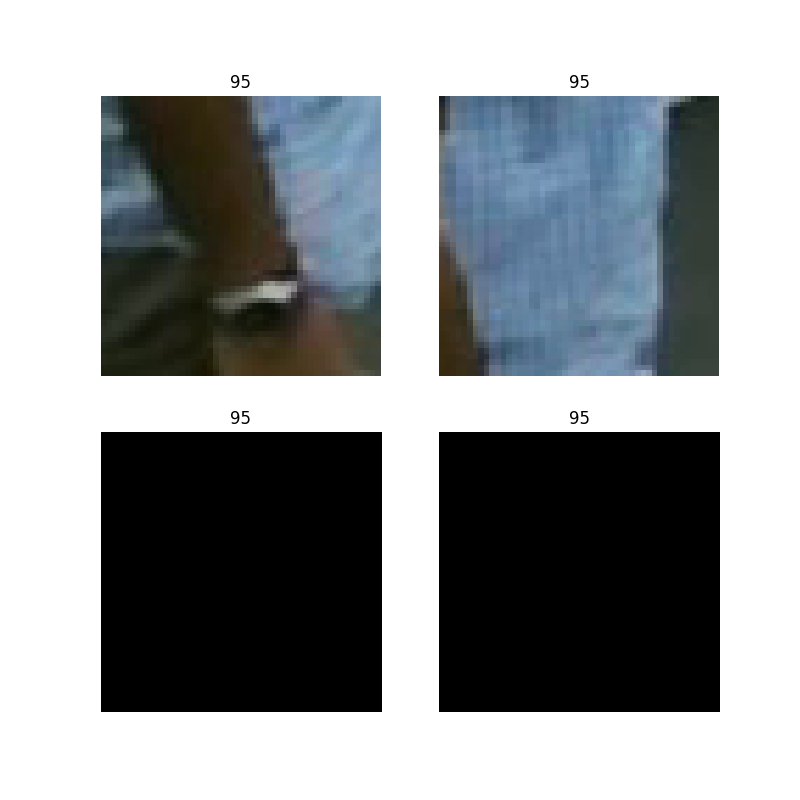

In [10]:
if hand_crops.shape[1] == 2:
    pad = np.zeros(hand_crops.shape, dtype=hand_crops.dtype)
    hand_crops = np.concatenate((hand_crops, pad), axis = 1)

# Using video for variable from above of shape (seq_len, 1080, 1920, 3)
f, (axs) = plt.subplots(2, 2)
f.set_size_inches(8, 8)
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')

s1_l = axs[0, 0].imshow(hand_crops[0, 0])
s1_r = axs[0, 1].imshow(hand_crops[0, 1])
s2_l = axs[1, 0].imshow(hand_crops[0, 2])
s2_r = axs[1, 1].imshow(hand_crops[0, 3])


def videoAnimation(frame_index):
    s1_l.set_data(hand_crops[frame_index, 0])
    s1_r.set_data(hand_crops[frame_index, 1])
    s2_l.set_data(hand_crops[frame_index, 2])
    s2_r.set_data(hand_crops[frame_index, 3])
    
    axs[0, 0].set_title(frame_index)
    axs[0, 1].set_title(frame_index)
    axs[1, 0].set_title(frame_index)
    axs[1, 1].set_title(frame_index)
    
    
    return s1_l

ani = animation.FuncAnimation(f, videoAnimation, interval = 200, frames = num_frames, repeat = False)